<a href="https://colab.research.google.com/github/iprameshwari/hacktiv8/blob/main/PYIM_Assgn_3_8_Irma_Prameshwari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Furniture_v1_00.tsv.gz

--2021-07-05 06:35:58--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Furniture_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.131.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.131.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148982796 (142M) [application/x-gzip]
Saving to: ‘amazon_reviews_us_Furniture_v1_00.tsv.gz’

amazon_reviews_us_F 100%[===================>] 142.08M  37.3MB/s    in 4.3s    

2021-07-05 06:36:03 (33.2 MB/s) - ‘amazon_reviews_us_Furniture_v1_00.tsv.gz’ saved [148982796/148982796]



# Import Libraries

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

import sklearn


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import seaborn as sns

import pydot

# Pembuatan DataFrame
Mengkonversikan data .tsv.gz menjadi DataFrame

In [50]:
dataset = pd.read_csv('/content/amazon_reviews_us_Furniture_v1_00.tsv.gz', sep='\t', compression="gzip", error_bad_lines=False)
dataset

b'Skipping line 2645: expected 15 fields, saw 22\nSkipping line 10770: expected 15 fields, saw 22\nSkipping line 13472: expected 15 fields, saw 22\nSkipping line 15785: expected 15 fields, saw 22\nSkipping line 22792: expected 15 fields, saw 22\nSkipping line 26618: expected 15 fields, saw 22\n'
b'Skipping line 70872: expected 15 fields, saw 22\nSkipping line 71165: expected 15 fields, saw 22\nSkipping line 118103: expected 15 fields, saw 22\n'
b'Skipping line 148666: expected 15 fields, saw 22\nSkipping line 150834: expected 15 fields, saw 22\nSkipping line 169344: expected 15 fields, saw 22\n'
b'Skipping line 197223: expected 15 fields, saw 22\nSkipping line 212607: expected 15 fields, saw 22\nSkipping line 227765: expected 15 fields, saw 22\nSkipping line 240130: expected 15 fields, saw 22\n'
b'Skipping line 281133: expected 15 fields, saw 22\nSkipping line 289460: expected 15 fields, saw 22\nSkipping line 311933: expected 15 fields, saw 22\nSkipping line 312121: expected 15 fields,

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,24509695,R3VR960AHLFKDV,B004HB5E0E,488241329,Shoal Creek Computer Desk,Furniture,4,0,0,N,Y,... desk is very study and it i has a beautifu...,This desk is very study and it i has a beauti...,2015-08-31
1,US,34731776,R16LGVMFKIUT0G,B0042TNMMS,205864445,Dorel Home Products Delaney Large Rectangular ...,Furniture,5,0,0,N,Y,Five Stars,Great item,2015-08-31
2,US,1272331,R1AIMEEPYHMOE4,B0030MPBZ4,124663823,Bathroom Vanity Table Jewelry Makeup Desk Benc...,Furniture,5,1,1,N,Y,Five Stars,"Perfect fit for my bedroom, been wanting one s...",2015-08-31
3,US,45284262,R1892CCSZWZ9SR,B005G02ESA,382367578,Sleep Master Ultima Comfort Memory Foam 6 Inch...,Furniture,3,0,0,N,Y,Good enough,"We use this on a trundle bed. So, it does not...",2015-08-31
4,US,30003523,R285P679YWVKD1,B005JS8AUA,309497463,"1 1/4"" GashGuards: Deluxe Rubberized Plastic B...",Furniture,3,0,0,N,N,Gash Gards for daybed,The product is fine...just seemed like it took...,2015-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791668,US,52940456,R1F7BNIK2R72ZC,B000050FF8,161996292,HoMedics BLTW-100 21-Inch AquaScape Twist Bubb...,Furniture,5,21,21,N,N,A great deal!,I sort of collect water fountains and most hav...,2000-11-07
791669,US,50562473,RVR3U3QA0D95B,B00000K0CL,328789022,Midnight Motion Lamp with White Lava and Blue ...,Furniture,5,10,11,N,N,This Lava Lamp is great!,I just got my lava lamp 2 days ago and I just ...,2000-10-28
791670,US,51137498,R1X5JB9UJRZW31,B00004SZ5M,547720134,Maglite Solitaire Incandescent 1-Cell AAA Flas...,Furniture,5,3,5,N,N,You can't go wrong owning one of these,"This is similar to other mag-lites, except in ...",2000-07-16
791671,US,49843940,R235PHRTF7BFK7,B00004SBJJ,685482907,"Le Creuset Stoneware 1-Quart Crock, White",Furniture,4,5,5,N,N,Everybody can use a little Le Creuset,I purchased this little pot as a gift for a fr...,2000-06-12


In [5]:
# menghitung total review yang masuk
print('Total Review Data')
print(len(dataset))

# menghitung jumlah produk yang telah direview
print('Unique Products')
print(len(dataset.groupby('product_id')))

# menghitung jumlah customer_id (unik) yang mengirim review
print('Unique Users')
print(len(dataset.groupby('customer_id')))

Total Review Data
791673
Unique Products
141131
Unique Users
655715


# Define function clean_text
Mendefinisikan fungsi untuk membersihkan text review dari karakter-karakter yang tidak diperlukan

In [6]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()

# Preprocess Review Data

In [7]:
# Menghilangkan data yang kosong
dataset.dropna(axis = 0, how ='any',inplace=True) 

# Membersihkan review dari karakter yang tidak diperlukan menggunakan fungsi clean_text
dataset['review_body'] = dataset['review_body'].apply(clean_text)       

# Menghitung jumlah kata dari setiap review
dataset['Num_words_text'] = dataset['review_body'].apply(lambda x:len(str(x).split())) 

# Menghitung jumlah review berdasarkan rating yang diberikan
print('-------Dataset --------')
print(dataset['star_rating'].value_counts())
print(len(dataset))
print('-------------------------')
max_review_data_sentence_length  = dataset['Num_words_text'].max()

# Kata terbanyak dalam 1 review
print('Train Max Sentence Length :'+str(max_review_data_sentence_length))

-------Dataset --------
5    447356
4    153569
3     73512
1     73272
2     43819
Name: star_rating, dtype: int64
791528
-------------------------
Train Max Sentence Length :4516


In [8]:
# Melihat statistik dari jumlah kata yang digunakan di review_body
dataset['Num_words_text'].describe()

count    791528.000000
mean         42.616189
std          58.947353
min           0.000000
25%          14.000000
50%          26.000000
75%          51.000000
max        4516.000000
Name: Num_words_text, dtype: float64

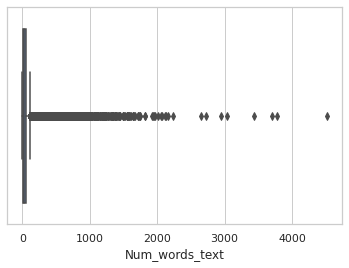

In [9]:
# Visualisasi persebaran jumlah kata per review

sns.set(style="whitegrid")
sns.boxplot(x=dataset['Num_words_text'])

In [13]:
# Memisahkan review menjadi Short dan Long review

mask = (dataset['Num_words_text'] < 100) & (dataset['Num_words_text'] >=10)
df_short_reviews = dataset[mask]
print('No of Short reviews : ' + str(len(df_short_reviews)))


mask = dataset['Num_words_text'] >= 100
df_long_reviews = dataset[mask]
print('No of Long reviews : ' + str(len(df_long_reviews)))

No of Short reviews : 419326
No of Long reviews : 69912


# Define get_sentiment function
Mendefinisikan fungsi untuk mengenali review berdasarkan rating yang diberikan. Apabila rating memiliki angka >= 3 maka akan dianggap sebagai review yang positif

In [14]:
def get_sentiment(rating):
    if rating == 5 or rating == 4 or rating ==3:
        return 1
    else:
        return 0

# Pembuatan data training, test, dan validation

In [21]:
# Mengambil review yang memiliki jumlah review lebih dari 20 dari Short Review

filtered_data = df_short_reviews.groupby('product_id').filter(lambda x: len(x) >= 20)
print('Filtered Data : ' + str(len(filtered_data)))
print(filtered_data ['star_rating'].value_counts())
filtered_data ['sentiment'] = filtered_data ['star_rating'].apply(get_sentiment)
#train_data = df_short_reviews.sample(n=200000, random_state =0)
train_data = filtered_data[['review_body','sentiment']]
print('Train data')
print(train_data['sentiment'].value_counts())


Filtered Data : 201067
5    106879
4     43729
3     20038
1     18739
2     11682
Name: star_rating, dtype: int64
Train data
1    170646
0     30421
Name: sentiment, dtype: int64


In [22]:
# Membuat data test berdasarkan produk yang memiliki jumlah review > =  10 

mask = dataset['Num_words_text'] < 100 
df_short_reviews = dataset[mask]
filtered_data = df_short_reviews.groupby('product_id').filter(lambda x: len(x) >= 10)
print('Filtered Data : ' + str(len(filtered_data)))
print(filtered_data ['star_rating'].value_counts())
filtered_data ['sentiment'] = filtered_data ['star_rating'].apply(get_sentiment)
test_data = filtered_data[['review_body','sentiment']]
print('Test data')
print(test_data['sentiment'].value_counts())

Filtered Data : 487191
5    283329
4     96418
3     43179
1     39915
2     24350
Name: star_rating, dtype: int64
Test data
1    422926
0     64265
Name: sentiment, dtype: int64


In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['review_body'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.5,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:100533
Class distributionCounter({1: 85323, 0: 15210})
Valid data len:100534
Class distributionCounter({1: 85323, 0: 15211})


In [24]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[1, 120, 14, 13]]


In [26]:
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['review_body'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=100)
x_valid = pad_sequences(x_valid, padding='post', maxlen=100)
x_test = pad_sequences(x_test, padding='post', maxlen=100)



train_labels = np.asarray(y_train )
valid_labels = np.asarray(y_valid)

test_labels = np.asarray(test_data['sentiment'].tolist())

print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

Train data len:100533
Class distributionCounter({1: 85323, 0: 15210})
Validation data len:100534
Class distributionCounter({1: 85323, 0: 15211})
Test data len:487191
Class distributionCounter({1: 422926, 0: 64265})


In [27]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break


======Train dataset ====
tf.Tensor(
[  269     3   244     2   250    63    32    23  3302   260     3    97
    11   338  3442     3 23427    32  2732   542   274     3   834    55
   912   218    32    12    23   171    63     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int32) tf.Tensor(1, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[   5    6   51    4    2  236    7    6  323  264  133  150  445  746
    2  122   17 7330    3  125  873  379  726  252    9  243  284  110
   13   57   58   13  340    4  152  870   16  507    3   35   15    0
    0    0    0    0    0    0    0 

# Pembuatan Model LSTM

In [28]:
max_features =50000
embedding_dim =16
sequence_length = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

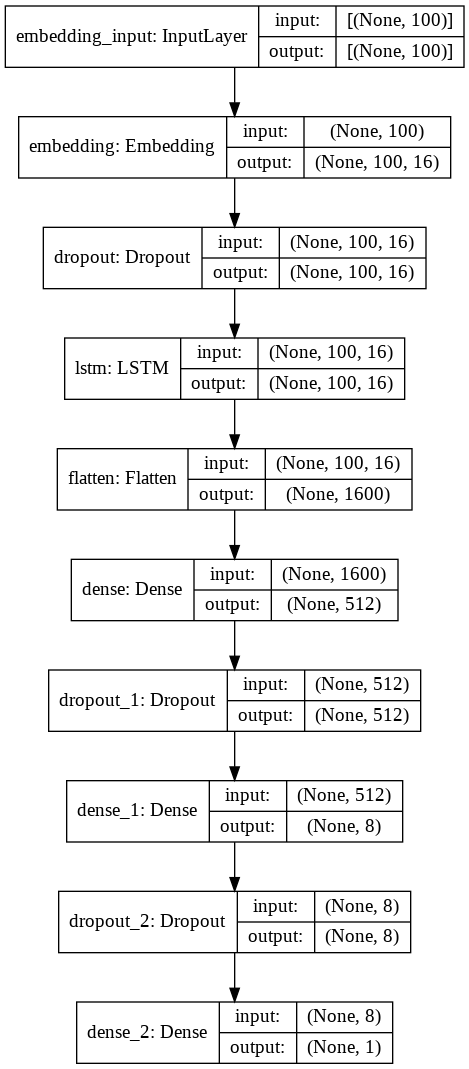

In [29]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

# Melakukan fitting model

In [30]:
epochs = 10
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)


Epoch 1/10
99/99 [==============================] - 53s 501ms/step - loss: 1.2547 - binary_accuracy: 0.8443 - val_loss: 0.4455 - val_binary_accuracy: 0.8859
Epoch 2/10
99/99 [==============================] - 50s 501ms/step - loss: 0.4173 - binary_accuracy: 0.8941 - val_loss: 0.3346 - val_binary_accuracy: 0.9180
Epoch 3/10
99/99 [==============================] - 49s 496ms/step - loss: 0.3652 - binary_accuracy: 0.9018 - val_loss: 0.3102 - val_binary_accuracy: 0.9198
Epoch 4/10
99/99 [==============================] - 49s 495ms/step - loss: 0.3451 - binary_accuracy: 0.9040 - val_loss: 0.2923 - val_binary_accuracy: 0.9211
Epoch 5/10
99/99 [==============================] - 49s 495ms/step - loss: 0.3344 - binary_accuracy: 0.9058 - val_loss: 0.2994 - val_binary_accuracy: 0.9138
Epoch 6/10
99/99 [==============================] - 49s 494ms/step - loss: 0.3275 - binary_accuracy: 0.9049 - val_loss: 0.2962 - val_binary_accuracy: 0.9180
Epoch 7/10
99/99 [==============================] - 50s 50

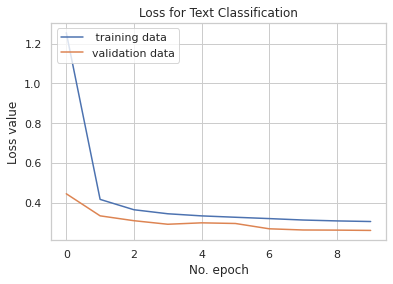

In [31]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

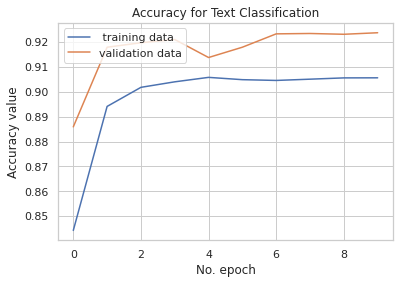

In [32]:
plt.plot(history.history['binary_accuracy'], label=' training data')
plt.plot(history.history['val_binary_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Penyimpanan Model dan Tokenizer

In [46]:
model.save('/content/tf_lstmmodel.h5') 
json_string = tokenizer.to_json()

In [47]:
import json
with open('/content/tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [37]:
valid_predict= model.predict(x_valid)
print(valid_predict[:10])

[[0.6842443 ]
 [0.77865547]
 [0.95130754]
 [0.9519041 ]
 [0.9994879 ]
 [0.39765665]
 [0.97310585]
 [0.9177675 ]
 [0.99798304]
 [0.9040487 ]]


# Menjalankan model yang sudah disimpan sebelumnya

In [48]:
new_model = tf.keras.models.load_model('/content/tf_lstmmodel.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

In [49]:
with open('/content/tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [41]:
x_test  = np.array( tokenizer.texts_to_sequences(test_data['review_body'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [42]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
predictions = new_model.predict(x_test)

In [43]:
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= 0.78),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < 0.78),0,test_data.pred_sentiment)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [44]:
labels = [0, 1]
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.59      0.87      0.70     64265
           1       0.98      0.91      0.94    422926

    accuracy                           0.90    487191
   macro avg       0.79      0.89      0.82    487191
weighted avg       0.93      0.90      0.91    487191

